In [24]:
###
# Code and examples of how to use the bootstrap in a myriad of different settings
# Date: Fall 2022
# Author Alex Parker
###

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
#import plotly.io as pio
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

sns.set_theme(context = 'notebook', style = 'whitegrid')

In [41]:
### Set the renderer to 'svg' or 'png' for static images (visible in github) or 'vscode' for interactive (not viisble in github)
plotly_renderer = 'svg'
#plotly_renderer = 'vscode'

if plotly_renderer in ['svg','png']:
    print("You've chosen static images for plotly data visualizations, these should display in github")
elif plotly_renderer == 'vscode':
    print("You've chosen vscode for the ploltly renderer, these images will not display in github but will be animated in a VScode notebook environment")
else:
     print("please choose an appropriate plotly image renderer")

You've chosen static images for plotly data visualizations, these should display in github


## Dataset Creation: Simulating a randomized experiment with user defined treatment effects

In [26]:
np.random.seed(4567)
n = 10000

### Generate Some Fake Data
age = pd.Series(np.random.randint(low = 18, high = 72, size = n), name = 'age', dtype = 'int64')
data_b = pd.Series(np.random.poisson(lam = 1.001, size = n), name = 'b')
gender = pd.Series(np.random.choice(a = ['male','female','other'], size = n, p = [.49,.48,.03]), name = 'gender', dtype = 'category')
married = pd.Series(np.random.choice(a = [True,False], size = n, p = [.4,.6]), name = 'married', dtype = 'boolean')
treatment = pd.Series(np.random.choice(a = ['control','treatment1','treatment2'], size = n, p = [.333,.333,.334]), name = 'treatment', dtype = 'category')

data = pd.concat([age ,gender ,married ,treatment], axis = 1)

# Generate target variable and amke dependant upon Age
data['spend'] = 14 + 20*np.log(data.age)*np.random.chisquare(df = 5, size =n)

# Generate treatment effects (in percent terms)
real_effect_1 = .05
real_effect_2 = -.08 

treatment1 = data.loc[data['treatment']=='treatment1', 'spend']
treatment1 = treatment1*np.random.normal(loc = 1 + real_effect_1,scale = .15, size =len(treatment1))

treatment2 = data.loc[data['treatment']=='treatment2', 'spend']
treatment2 = treatment2*np.random.normal(loc = 1 + real_effect_2, scale = .2, size =len(treatment2))

data.loc[data['treatment']=='treatment1','spend'] = treatment1
data.loc[data['treatment']=='treatment2','spend'] = treatment2

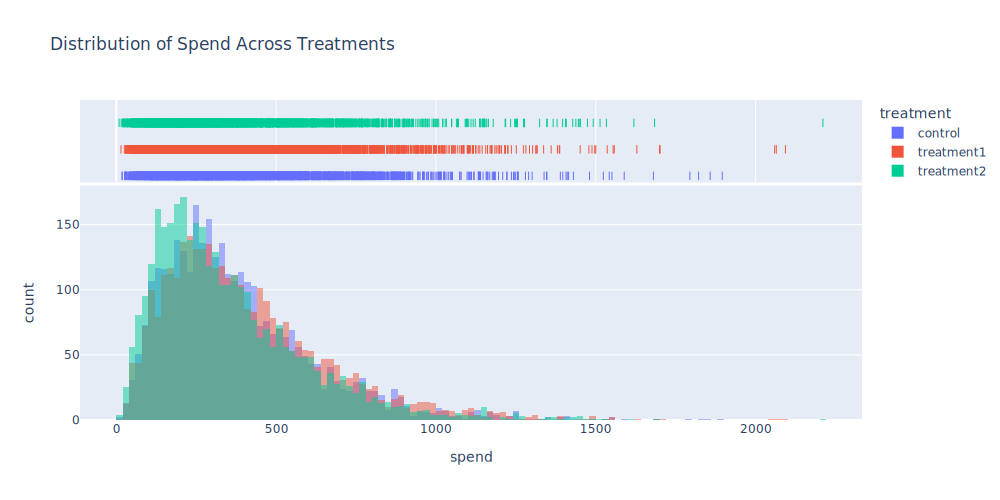

In [43]:
fig = px.histogram(data, 
    x = 'spend', 
    color = 'treatment',
    marginal = 'rug',
    title = 'Distribution of Spend Across Treatments',
    opacity= .50)
fig.update_layout(barmode = 'overlay', height = 500, width = 1000)
fig.show(renderer = plotly_renderer)

## Bootrapped Estimates of the Effect Size Using the Difference of Means

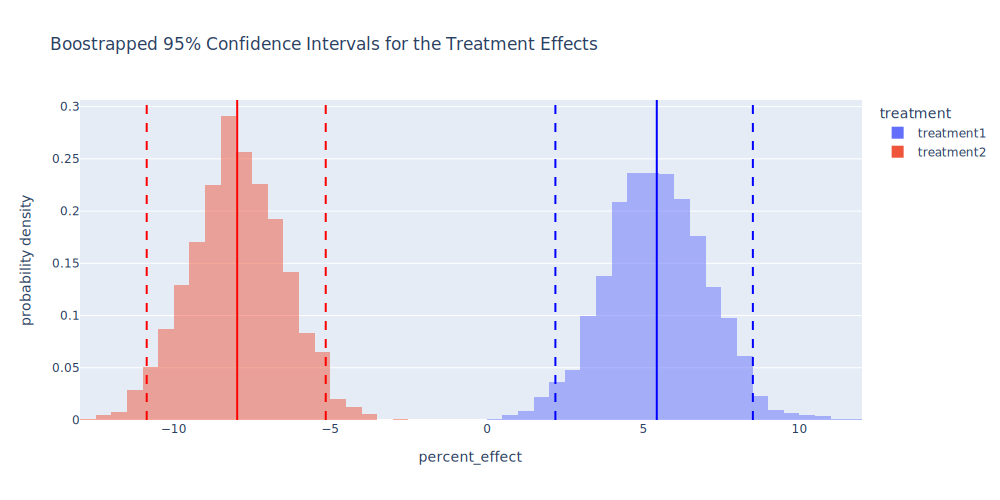

In [44]:
### Bootstrapped confidence interval for the percent effect between treatments and control
ols_boot_1 = []
ols_boot_2 = []
n = 2000

for i in range(n):
    boot_sample = data.sample(frac = 1, replace = True)
    boot_mean = boot_sample.groupby('treatment', as_index = False)['spend'].mean()
    treat1_eff = (boot_mean.iloc[1,1] - boot_mean.iloc[0,1]) / boot_mean.iloc[0,1] * 100
    treat2_eff = (boot_mean.iloc[2,1] - boot_mean.iloc[0,1]) / boot_mean.iloc[0,1] * 100
    ols_boot_1.append(treat1_eff)
    ols_boot_2.append(treat2_eff)

ols_boot_1 = pd.DataFrame(ols_boot_1, columns = ['percent_effect']).assign(treatment = 'treatment1')
ols_boot_2 = pd.DataFrame(ols_boot_2, columns = ['percent_effect']).assign(treatment = 'treatment2')
boots = pd.concat([ols_boot_1, ols_boot_2], axis = 0)

#%%

fig = px.histogram(boots, 
    x = 'percent_effect', 
    color = 'treatment', 
    opacity= .5, 
    histnorm = 'probability density',
    title = 'Boostrapped 95% Confidence Intervals for the Treatment Effects' )
fig.add_vline(x = ols_boot_1.percent_effect.mean(), line_color = 'blue')
fig.add_vline(x = ols_boot_1.percent_effect.quantile(.975), line_color = 'blue', line_dash = 'dash')
fig.add_vline(x = ols_boot_1.percent_effect.quantile(.025), line_color = 'blue', line_dash = 'dash')

fig.add_vline(x = ols_boot_2.percent_effect.mean(), line_color = 'red')
fig.add_vline(x = ols_boot_2.percent_effect.quantile(.975), line_color = 'red', line_dash = 'dash')
fig.add_vline(x = ols_boot_2.percent_effect.quantile(.025), line_color = 'red', line_dash = 'dash')

fig.update_layout(height = 500, width = 1000)
fig.show(renderer = plotly_renderer)

### How accurate are the difference of mean estimates?

In [29]:
real_effects = pd.DataFrame([['treatment1',real_effect_1*100],['treatment2',real_effect_2*100]], columns = ['treatment','real_effect'])

boots_gp = boots.groupby('treatment', as_index = False).agg(
        ci_lower = ('percent_effect', lambda x: x.quantile(.025)),
        mean = ('percent_effect', 'mean'),
        ci_upper = ('percent_effect', lambda x: x.quantile(.975)))

boots_gp = boots_gp.merge(real_effects, how = 'inner', on = 'treatment')
boots_gp['difference'] = boots_gp['mean'] - boots_gp['real_effect']
boots_gp

,treatment,ci_lower,mean,ci_upper,real_effect,difference
0,treatment1,2.404677,5.422616,8.760683,5.0,0.422616
1,treatment2,-10.758896,-7.998174,-5.167514,-8.0,0.001826


## Using the Bootsrap with OLS: Are the results more accurate after including controls?

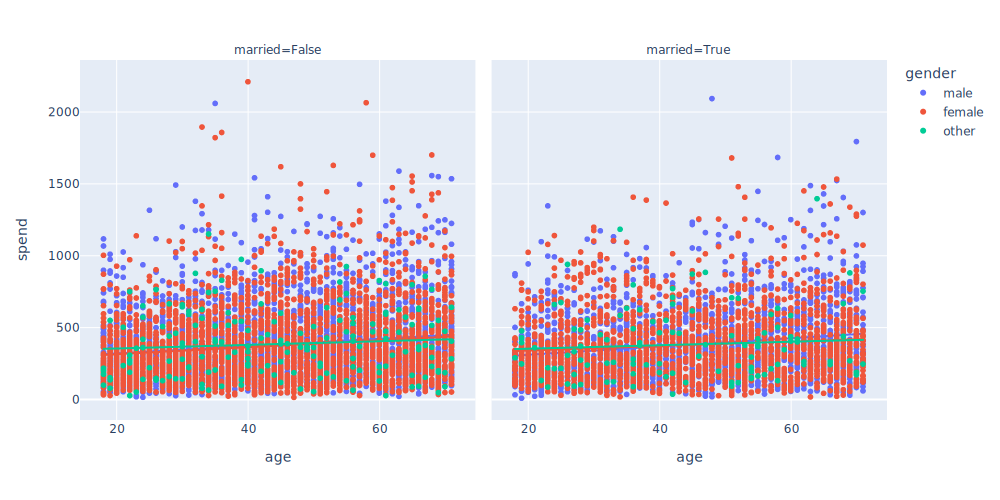

In [45]:
### Pre Regression plots to inform the OLS model

fig = px.scatter(data, 
    x = 'age', 
    y = 'spend', 
    color = 'gender',
    facet_col = 'married', 
    trendline = 'ols')
fig.update_layout(height = 500, width = 1000)
fig.show(renderer = plotly_renderer)

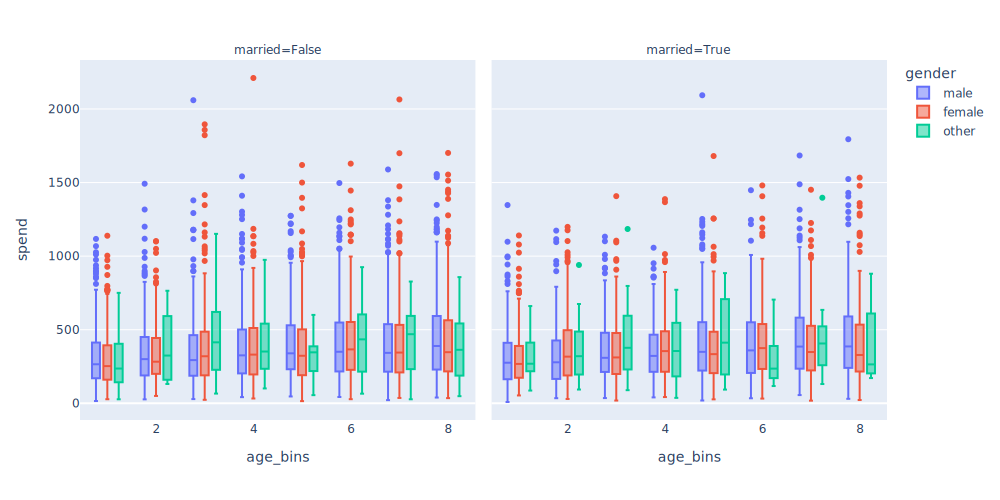

In [46]:
data['age_bins'] = pd.cut(data.age, bins = 8, labels = [1,2,3,4,5,6,7,8])
fig = px.box(data, x = 'age_bins', y = 'spend', color = 'gender', facet_col = 'married')
fig.update_layout(height = 500, width = 1000)
fig.show(renderer = plotly_renderer)

In [31]:
# Run an OLS model
model = smf.ols('np.log(spend) ~ age + treatment', data=data)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(spend)   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     100.7
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           3.00e-64
Time:                        14:28:21   Log-Likelihood:                -10258.
No. Observations:               10000   AIC:                         2.052e+04
Df Residuals:                    9996   BIC:                         2.055e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   5.4743      0.023    242.684      0.000       5.430       5.518
treatment[T.treatment1]     0.0443      0.017      2.668      0.008       0.012       0.077
treatment[T.treatment2]    -0.1126      0.016     -6.824      0.000      -0.145      -0.080
age                         0.0062      0.000     14.345      0.000       0.005       0.007
==============================================================================
Omnibus:                      424.081   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              489.702
Skew:                          -0.498   Prob(JB):                    4.60e-107
Kurtosis:                       3.427   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
###Boostrapped confidence interval for OLS models
ols_boot_1 = []
ols_boot_2 = []
ols_boot_age = []

n = 2000

for i in range(n):
    boot_data = data.sample(frac = 1, replace = True)
    boot_model = smf.ols('np.log(spend) ~ age + treatment', data=boot_data).fit()
    treat1_eff = boot_model.params[1]*100
    treat2_eff = boot_model.params[2]*100
    age_eff = boot_model.params[3]*100
    ols_boot_1.append(treat1_eff)
    ols_boot_2.append(treat2_eff)
    ols_boot_age.append(age_eff)

ols_boot_1 = pd.DataFrame(ols_boot_1, columns = ['percent_effect']).assign(param = 'treatment1')
ols_boot_2 = pd.DataFrame(ols_boot_2, columns = ['percent_effect']).assign(param = 'treatment2')
ols_boot_age = pd.DataFrame(ols_boot_age, columns = ['percent_effect']).assign(param = 'age')
ols_boots = pd.concat([ols_boot_1,ols_boot_2,ols_boot_age], axis = 0)


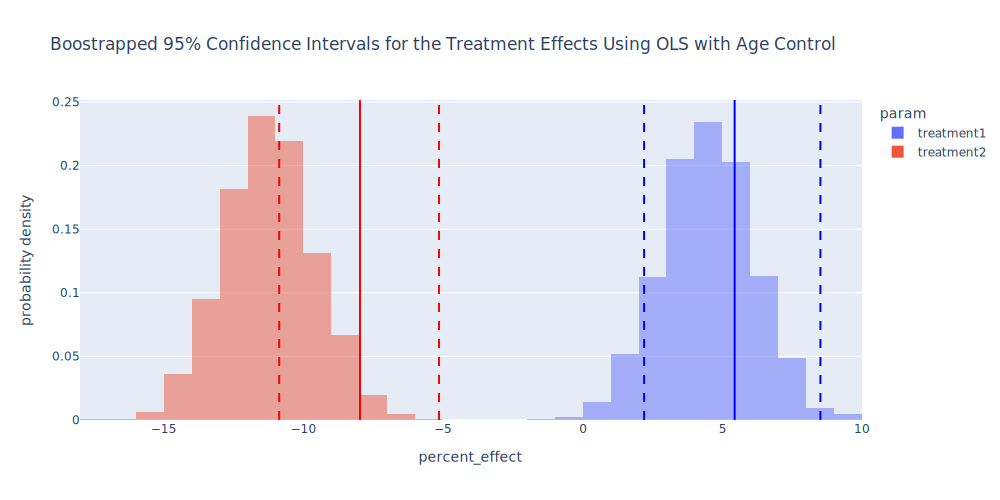

In [47]:

### PLotting the results of the OLS Boostrap
fig = px.histogram(ols_boots.query("not param =='age'"), 
    x = 'percent_effect', 
    color = 'param', 
    opacity= .5, 
    histnorm = 'probability density',
    title = 'Boostrapped 95% Confidence Intervals for the Treatment Effects Using OLS with Age Controls' )
fig.add_vline(x = ols_boot_1.percent_effect.mean(), line_color = 'blue')
fig.add_vline(x = ols_boot_1.percent_effect.quantile(.975), line_color = 'blue', line_dash = 'dash')
fig.add_vline(x = ols_boot_1.percent_effect.quantile(.025), line_color = 'blue', line_dash = 'dash')

fig.add_vline(x = ols_boot_2.percent_effect.mean(), line_color = 'red')
fig.add_vline(x = ols_boot_2.percent_effect.quantile(.975), line_color = 'red', line_dash = 'dash')
fig.add_vline(x = ols_boot_2.percent_effect.quantile(.025), line_color = 'red', line_dash = 'dash')
fig.update_layout(height = 500, width = 1000)
fig.show(renderer = plotly_renderer)

In [34]:
ols_boots_gp = ols_boots.groupby('param', as_index = False).agg(
        ci_lower = ('percent_effect', lambda x: x.quantile(.025)),
        mean = ('percent_effect', 'mean'),
        ci_upper = ('percent_effect', lambda x: x.quantile(.975)))

ols_boots_gp = ols_boots_gp.merge(real_effects, how = 'inner', left_on = 'param', right_on = 'treatment')
ols_boots_gp['difference'] = ols_boots_gp['mean'] - ols_boots_gp['real_effect']


## Which is more accurate?

#### Difference of Means:

In [35]:
boots_gp

,treatment,ci_lower,mean,ci_upper,real_effect,difference
0,treatment1,2.404677,5.422616,8.760683,5.0,0.422616
1,treatment2,-10.758896,-7.998174,-5.167514,-8.0,0.001826


#### OLS with Age controls:

In [36]:
ols_boots_gp

,param,ci_lower,mean,ci_upper,treatment,real_effect,difference
0,treatment1,1.167305,4.474575,7.705252,treatment1,5.0,-0.525425
1,treatment2,-14.353026,-11.221885,-8.016651,treatment2,-8.0,-3.221885


## Using the Bootsrap for the Median

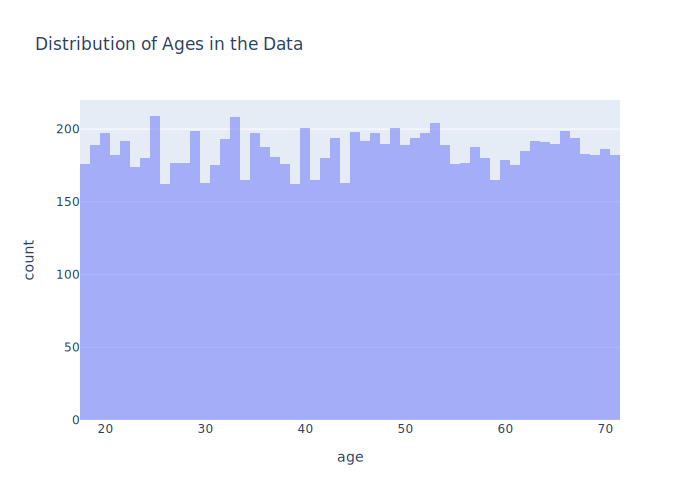

The median age in the data is: 45.0


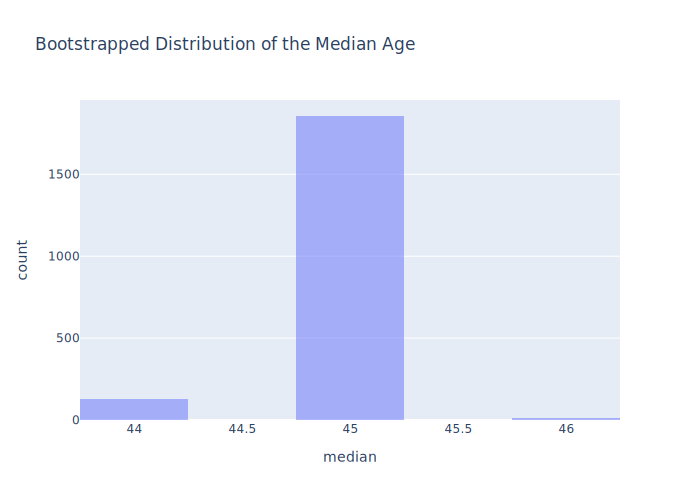

In [37]:


### Boostrapped confidence interval for the median 

fig = px.histogram(data, 
    x = 'age', 
    opacity = .5, 
    title = "Distribution of Ages in the Data")
fig.show(renderer = plotly_renderer)

print("The median age in the data is:", data.age.median())

boot_med = []
n = 2000

for i in range(n):
    boot_sample = data['age'].sample(frac = 1, replace = True)
    boot_median = boot_sample.median()
    boot_med.append(boot_median)

boot_med = pd.DataFrame(boot_med, columns= ['median'])

fig = px.histogram(boot_med, 
    x = 'median', 
    opacity = .5,
    title = "Bootstrapped Distribution of the Median Age")
fig.show(renderer = plotly_renderer)

